# NSL-KDD Classification

## Install Dependencies

In [25]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tensorflow
!pip install imblearn

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [47]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from imblearn.metrics import geometric_mean_score
import joblib

## Classification Model Functions

### Function to Load the Test and Train Data

In [27]:
# Function to read and display basic info of datasets
def load_data(train_path, test_path):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    return data_train, data_test

### Function to plot the data distribution

In [28]:
# Function to plot pie chart of a categorical column
def plot_pie_chart(column_name, frame):
    if column_name not in frame.columns:
        print(f"Column '{column_name}' not found in the dataset.")
        return
    column_data = frame[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(column_data, labels=column_data.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {column_name}')
    plt.show()

### Function to pre-process that data 

In [29]:
# Outcome mapping for the labels
outcome_mapping = {
    'normal': 0,
    'dos': 1,
    'probe': 2,
    'r2l': 3,
    'u2r': 4,
}

# Scaling function using RobustScaler
def scale_numeric_features(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    return pd.DataFrame(std_scaler_temp, columns=cols)

# Function to preprocess the data
def preprocess(dataframe, cat_cols):
    df = dataframe.copy()
    df_num = df.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = scale_numeric_features(df_num, num_cols)

    df.drop(labels=num_cols, axis="columns", inplace=True)
    df[num_cols] = scaled_df[num_cols]
    
    # Map label column based on the outcome_mapping
    df['label'] = df['label'].map(outcome_mapping)
    
    # One-hot encode categorical columns
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'], drop_first=True)
    
    return df

## Evaluation Function for F1 Accuracy and G-Mean Score

In [33]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def evaluate_classification(model, model_name, x_train, x_test, y_train, y_test, metrics_dict):
    """
    Evaluate a classification model using multiple metrics: F1 score, accuracy, and G-mean.
    
    Parameters:
    -----------
    model : sklearn classifier object
        The trained classification model
    model_name : str
        Name of the model for printing and storing results
    x_train : array-like
        Training features
    x_test : array-like
        Test features
    y_train : array-like
        Training labels
    y_test : array-like
        Test labels
    metrics_dict : dict
        Dictionary to store the evaluation metrics
        
    Returns:
    --------
    dict
        Updated metrics dictionary with new model results
    """
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    g_mean = geometric_mean_score(y_test, y_pred, average='weighted')
    
    # Store metrics in dictionary
    metrics_dict[model_name] = {
        'F1 Score': f1,
        'Accuracy': accuracy,
        'G-mean': g_mean
    }
    
    # Print results
    print(f"\nResults for {model_name}:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"G-mean Score: {g_mean:.4f}")
    
    return metrics_dict


## Main Function for Running and Testing models

In [48]:
def main(train_path, test_path, cat_cols):
    # Load the data
    data_train, data_test = load_data(train_path, test_path)

    #data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42)

    plot_pie_chart('label', data_train)
    
    # Preprocess datasets and align columns
    scaled_train = preprocess(data_train, cat_cols)
    scaled_test = preprocess(data_test, cat_cols)
    scaled_test = scaled_test.reindex(columns=scaled_train.columns, fill_value=0)
    
    print(scaled_train.size, scaled_test.size)
    scaled_train = scaled_train.dropna()
    scaled_test = scaled_test.dropna()
    print(scaled_train.size, scaled_test.size)

    # Separate features and labels
    x_train = scaled_train.drop(['label'], axis=1).values
    y_train = scaled_train['label'].values
    x_test = scaled_test.drop(['label'], axis=1).values
    y_test = scaled_test['label'].values

    # Dictionary to store evaluation metrics for each model
    kernal_evals = {}

    # Example of using the evaluation function
    lin_svc = svm.LinearSVC().fit(x_train, y_train)
    evaluate_classification(lin_svc, "Linear SVC", x_train, x_test, y_train, y_test, kernal_evals)
    
    dt = DecisionTreeClassifier().fit(x_train, y_train)
    evaluate_classification(dt, "Decision Tree", x_train, x_test, y_train, y_test, kernal_evals)

    rf = RandomForestClassifier().fit(x_train, y_train)
    evaluate_classification(rf, "Random Forest", x_train, x_test, y_train, y_test, kernal_evals)
    joblib.dump(lin_svc, "linear_svc_model.pkl")
    joblib.dump(dt, "decision_tree_model.pkl")
    joblib.dump(rf, "random_forest_model.pkl")

    

## Performance Evalution for Base Models

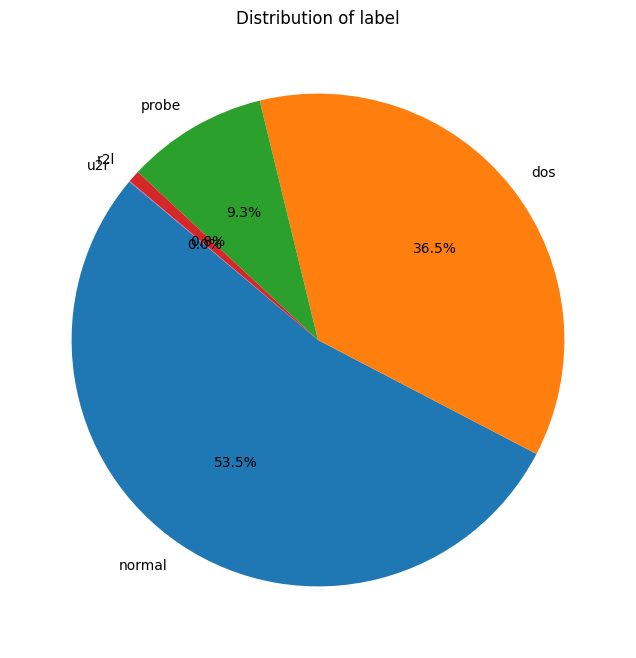

15116760 2705280
15116760 2705280


/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Linear SVC:
F1 Score: 0.6346
Accuracy: 0.6762
G-mean Score: 0.7511

Results for Decision Tree:
F1 Score: 0.7221
Accuracy: 0.7626
G-mean Score: 0.8191

Results for Random Forest:
F1 Score: 0.7000
Accuracy: 0.7496
G-mean Score: 0.7871


In [49]:
main('KDDTrain.CSV', 'KDDTest.CSV',  cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'])

## Performance Evaluation along with GAN Generated Data

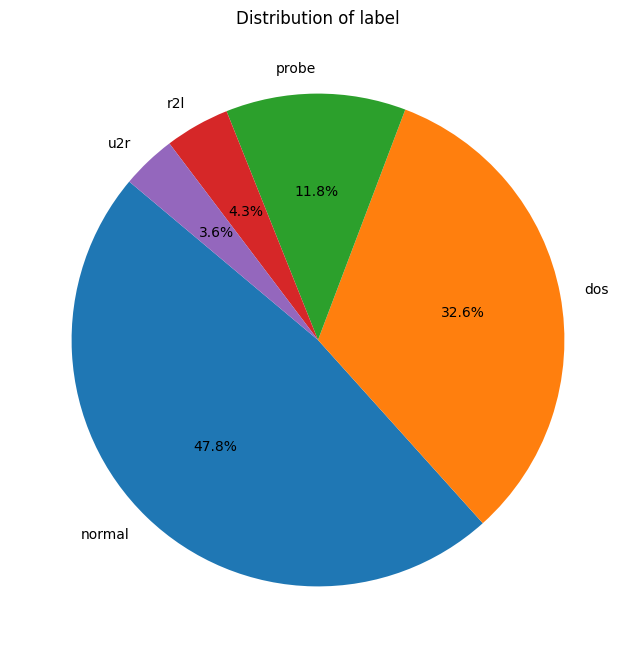

16916760 2705280
16916760 2705280


/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Linear SVC:
F1 Score: 0.6220
Accuracy: 0.6445
G-mean Score: 0.7447

Results for Decision Tree:
F1 Score: 0.7375
Accuracy: 0.7465
G-mean Score: 0.8150

Results for Random Forest:
F1 Score: 0.7615
Accuracy: 0.7868
G-mean Score: 0.8242


In [44]:
main('KDDTrainSynthatic.CSV', 'KDDTest.CSV',  cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'])

## Performance with GAN Data and PCA 

In [45]:
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
import pandas as pd

# Load the training and test data
data_train, data_test = load_data('KDDTrain.CSV', 'KDDTest.CSV')

# Define the list of columns to filter
selected_columns = ['count', 'diff_srv_rate', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
                    'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 
                    'dst_host_srv_serror_rate', 'flag', 'label', 'logged_in', 'protocol_type', 'rerror_rate', 'serror_rate', 
                    'service', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate']

# Filter both datasets to include only the selected columns
filtered_train_data = data_train[selected_columns]
filtered_test_data = data_test[selected_columns]

# Load the pre-trained synthesizer
loaded_synthesizer = CTGANSynthesizer.load(filepath='nsl-kdd-gan-minority-pca.pkl')

# Generate synthetic data for label 'r2l'
condition_r2l = Condition(num_rows=5000, column_values={'label': 'r2l'})
synthetic_data_r2l = loaded_synthesizer.sample_from_conditions(conditions=[condition_r2l])
synthetic_data_r2l = synthetic_data_r2l.round(2)

# Generate synthetic data for label 'u2r'
condition_u2r = Condition(num_rows=5000, column_values={'label': 'u2r'})
synthetic_data_u2r = loaded_synthesizer.sample_from_conditions(conditions=[condition_u2r])
synthetic_data_u2r = synthetic_data_u2r.round(2)

print(sorted(synthetic_data_r2l.columns.tolist()))
print(sorted(filtered_train_data.columns.tolist()))

# Concatenate the original train data with the synthetic data
pca_train_data_with_synthetic = pd.concat([filtered_train_data, synthetic_data_r2l, synthetic_data_u2r], ignore_index=True)

# Save the final datasets to CSV
pca_train_data_with_synthetic.to_csv('pca_train_data.csv', index=False)
filtered_test_data.to_csv('pca_test_data.csv', index=False)


/opt/homebrew/anaconda3/envs/nsl/lib/python3.8/site-packages/sdv/_utils.py:290: SDV Version Warning: You are currently on SDV version 1.17.2 but this synthesizer was created on version 1.17.1. The latest bug fixes and features may not be available for this synthesizer. To see these enhancements, create and train a new synthesizer on this version.
  warnings.warn(message, SDVVersionWarning)
Sampling conditions: 100%|██████████| 5000/5000 [00:02<00:00, 2187.84it/s]


['count', 'diff_srv_rate', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'flag', 'label', 'logged_in', 'protocol_type', 'rerror_rate', 'serror_rate', 'service', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate']
['count', 'diff_srv_rate', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'flag', 'label', 'logged_in', 'protocol_type', 'rerror_rate', 'serror_rate', 'service', 'srv_count', 'srv_diff_host_rate', 'srv_rerror_rate', 'srv_serror_rate']


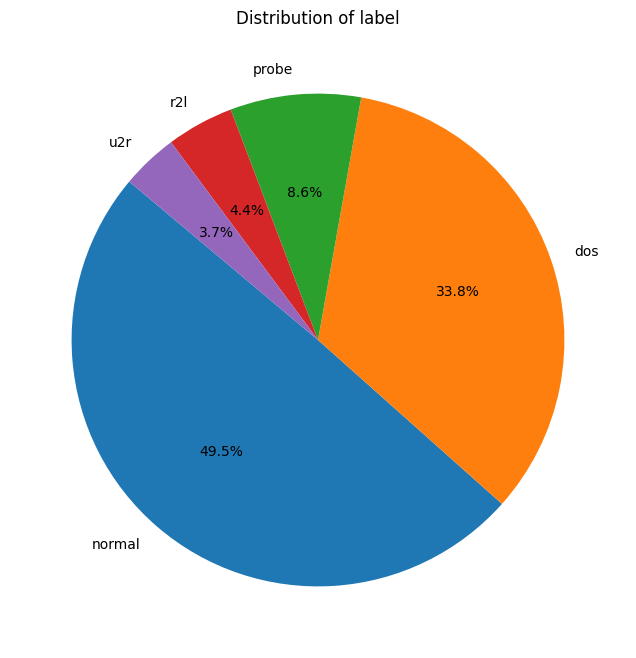

13461327 2231856
13461327 2231856


/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Linear SVC:
F1 Score: 0.6357
Accuracy: 0.6658
G-mean Score: 0.7514

Results for Decision Tree:
F1 Score: 0.6540
Accuracy: 0.6000
G-mean Score: 0.7295

Results for Random Forest:
F1 Score: 0.7332
Accuracy: 0.7411
G-mean Score: 0.7989


In [46]:
main('pca_train_data.CSV', 'pca_test_data.CSV',  cat_cols = ['protocol_type', 'service', 'flag', 'logged_in', 'label'])

In [64]:
loaded_model = joblib.load("linear_svc_model.pkl")

In [69]:
data_train, data_test = load_data('KDDTrainSynthatic.CSV', 'KDDTest.CSV')
cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label']

data_test = data_test.head(2)
# Preprocess datasets and align columns
scaled_train = preprocess(data_train, cat_cols)
scaled_test = preprocess(data_test, cat_cols)
scaled_test = scaled_test.reindex(columns=scaled_train.columns, fill_value=0)

# Separate features and labels
x_train = scaled_train.drop(['label'], axis=1).values
y_train = scaled_train['label'].values
x_test = scaled_test.drop(['label'], axis=1).values
y_test = scaled_test['label'].values

print(x_test)

y_pred = loaded_model.predict(x_test)


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. -1. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Implement and Evaluate Neural Network 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                7680      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               66048     
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 128)              

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


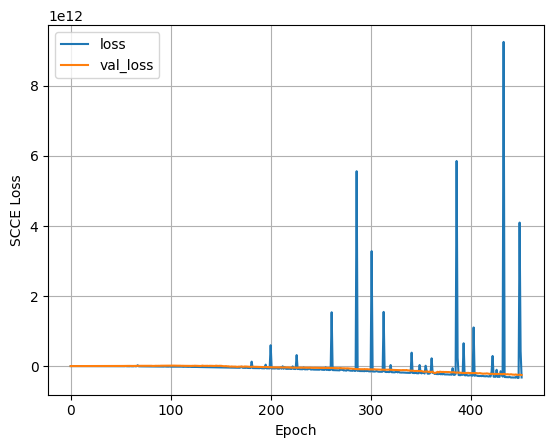

In [67]:
data_train, data_test = load_data('KDDTrain.CSV', 'KDDTest.CSV')

cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label']

scaled_train = preprocess(data_train, cat_cols)
scaled_test = preprocess(data_test, cat_cols)
scaled_test = scaled_test.reindex(columns=scaled_train.columns, fill_value=0)

x_train = scaled_train.drop(['label'], axis=1).values.astype(float)
y_train = scaled_train['label'].values.astype(float)
x_test = scaled_test.drop(['label'], axis=1).values.astype(float)
y_test = scaled_test['label'].values.astype(float)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, verbose=0)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)